In [12]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import pyedflib
import mne
import neurokit2 as nk2
import p_tqdm
from scipy.stats import trim_mean
from scipy import signal
from scipy.optimize import least_squares
import statsmodels.api as sm
from collections import defaultdict
import wfdb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor
from scipy.interpolate import interp1d
import shutil
from scipy.signal import savgol_filter
import scipy

In [2]:
%store -r signals_list

In [3]:
dfs = defaultdict(lambda: defaultdict(pd.DataFrame))

for files in glob.glob('/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/*'):
    key = os.path.splitext(os.path.basename(files))[1]
    base_name = os.path.splitext(os.path.basename(files))[0]
    sensor = base_name.split('_')[-1]
    if key == '.edf':
        file = mne.io.read_raw_edf(files)
        file = file.to_data_frame()
    else:
        file = pd.read_csv(files, on_bad_lines='skip', names=['R-R Interval (ms)'])
    dfs[sensor][base_name] = file

Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x010_NEXUS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x001_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x011_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x004_NEXUS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x013_HX.edf...
EDF file detected
Se

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x007_FAROS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x002_HX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x010_HX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x005_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiologic

In [4]:
dfs_test=[]
for key1 in dfs:
    for key2 in dfs[key1]:
        if "FAROS" in key2:
            df=dfs[key1][key2]
            dfs_test.append(df)

In [689]:
accel_test=dfs_test[3][['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']]

b,a =signal.butter(3,(3,60), btype='bandpass', fs=1000)

filtered_accels=[]
for i in accel_test:
    filtered_accel=signal.filtfilt(b, a, accel_test[i])
    filtered_accels.append(filtered_accel)
    
filtered_accels=pd.concat([pd.Series(i) for i in filtered_accels], axis=1)

#Decreasing the scale of the data so it is easier to establish minimum height of Amplitude

standard_accels=filtered_accels/100000 

standard_accels['time']=dfs_test[3]['time']
filtered_accels['time']=dfs_test[3]['time']

In [690]:
standard_accels

,0,1,2,time
0,-15.875058,5.610249,-10.823451,0.000
1,11.124153,3.252152,-49.130207,0.001
2,36.086137,0.516014,-88.965033,0.002
3,57.146135,-2.958940,-131.546640,0.003
4,72.795955,-7.440071,-177.410479,0.004
...,...,...,...,...
2629995,-817.949261,-992.379316,-649.882717,2629.995
2629996,-708.025610,-880.057259,-557.093225,2629.996
2629997,-585.009686,-765.645306,-460.212966,2629.997
2629998,-453.176452,-650.795234,-361.309702,2629.998


Zoom in on a segment of the visible walking data to establish a height threshold for the data

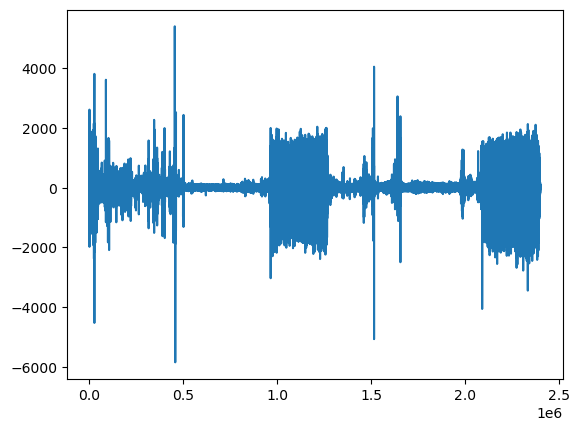

In [691]:
#I tried it on the whole df above and then am trying it again after cutting out same data at the end to see if it
#improves cadence calculations

test=standard_accels[:2400000]
plt.plot(standard_accels[1][:2400000])

In [653]:
whole_signal_peaks, whole_signal_heights=scipy.signal.find_peaks(test[1], height=(1000,2000), threshold=.62)

whole_signal_peaks=pd.Series(whole_signal_peaks)/1000

# Attempting a sliding window approach because the difference approach to get the segment was not wokring (not shown)

In [654]:
whole_signal_peaks

0        13.123
1        13.602
2        14.482
3        14.505
4        15.631
         ...   
812    2386.761
813    2388.706
814    2389.768
815    2390.737
816    2394.398
Length: 817, dtype: float64

In [163]:
standard_accels[1]

0            5.610249
1            3.252152
2            0.516014
3           -2.958940
4           -7.440071
              ...    
2629995   -992.379316
2629996   -880.057259
2629997   -765.645306
2629998   -650.795234
2629999   -536.717460
Name: 1, Length: 2630000, dtype: float64

In [216]:
window=whole_signal_peaks[:75]

In [217]:
threshold_test_2=window.diff().sum()

In [218]:
threshold_test_2

952.476

In [205]:
threshold=1.5*len(window)+10

In [215]:
threshold

85.0

In [212]:
threshold_test=whole_signal_peaks[70:150].diff().sum()

In [213]:
threshold_test

585.352

In [214]:
whole_signal_peaks[70:150]

70      457.473
71      457.679
72      460.614
73      961.904
74      965.599
         ...   
145    1040.257
146    1040.709
147    1041.335
148    1042.356
149    1042.825
Length: 80, dtype: float64

In [228]:
threshold_test_3=whole_peak_times[:50].diff().sum()
threshold_test_4=whole_peak_times[100:150].diff().sum()

In [229]:
threshold_test_3

101.28500000000001

In [230]:
threshold_test_4

32.40100000000007

In [505]:
def process_peak_times(series_of_peak_times, window_size, threshold=1.5*len(window)+10):
    times=[]
    for i in range(0, len(series_of_peak_times), window_size):
        if series_of_peak_times[i:i+window_size].diff().sum() > threshold:
            pass
        else:
            times.append(series_of_peak_times[i:i+window_size])
    return times

In [655]:
result=process_peak_times(whole_signal_peaks, 75)

result=pd.concat(result, axis=0)

result=result.reset_index()
result['diff']=result[0].diff()

In [656]:
result

,index,0,diff
0,75,967.039,NaN
1,76,969.671,2.632
2,77,970.685,1.014
3,78,972.819,2.134
4,79,973.845,1.026
...,...,...,...
662,812,2386.761,1.253
663,813,2388.706,1.945
664,814,2389.768,1.062
665,815,2390.737,0.969


In [657]:
activity_segment_times=result[result['diff']>50]

#Add the index of the value preceding the change in difference
added_value=activity_segment_times.index[0]-1

activity_segment_times=activity_segment_times.append(result.iloc[added_value])
activity_segment_times=activity_segment_times.append(result.iloc[0])

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/3305336973.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[added_value])
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/3305336973.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[0])


In [658]:
activity_segment_times=activity_segment_times[0]
activity_segment_times=activity_segment_times.sort_values()

activity_segment_times=list(activity_segment_times)
activity_segment_times=[int(i) for i in activity_segment_times]
activity_segment_times.append(0)
activity_segment_times.sort()

In [659]:
activity_segment_times

[0, 967, 1223, 2090]

In [660]:
def audit_activity_segment_times(time_segments, peaks):
    if len(time_segments) < 5:
        time_segments.append(0) if 0 not in time_segments else None
        if not time_segments or abs(time_segments[-1] - peaks[0].to_numpy()[-1]) > 250:
            time_segments.append(int(peaks[0].to_numpy()[-1]))
    if len(time_segments)==5:
        pass
    if len(time_segments)>5:
        raise ValueError(f"More than 5 time indexes detected. Check data. Time Indexes currently: {time_segments}")
    if len(time_segments) != 5:
            raise ValueError(f'time_segments missing values. Len must be equal to 5. List is currently: {time_segments}')
            
    return time_segments

In [663]:
activity_segment_times

[0, 967, 1223, 2090, 2394]

In [662]:
activity_segment_times=audit_activity_segment_times(activity_segment_times, result)

# Right here I need a logic audit of the activity segments...

Essentially it needs to do a few things:
1) audit to check that there are 5 values in the list...
2) check that they are spaced out by at least a certain value....
3) If they aren't spaced out, return an error to check teh data for further filtering
4) If there arent 5 values, check if a start or end value needs to be added..easy fix and append it...if a middle value needs to be appended...cycle back through the data and change some of the parameters to adjust

In [583]:
segments=pd.cut(filtered_accels['time'], activity_segment_times)

In [584]:
activity_segments=[filtered_accels[segments == category] for category in segments.cat.categories]

In [585]:
activity_segments

[                   0             1             2     time
 1       1.112415e+06  3.252152e+05 -4.913021e+06    0.001
 2       3.608614e+06  5.160141e+04 -8.896503e+06    0.002
 3       5.714614e+06 -2.958940e+05 -1.315466e+07    0.003
 4       7.279596e+06 -7.440071e+05 -1.774105e+07    0.004
 5       8.200637e+06 -1.306914e+06 -2.262101e+07    0.005
 ...              ...           ...           ...      ...
 966996 -5.769793e+07  1.792709e+07  4.327944e+07  966.996
 966997 -5.643308e+07  2.163784e+07  4.263868e+07  966.997
 966998 -5.251055e+07  1.968662e+07  3.802998e+07  966.998
 966999 -4.620579e+07  1.269853e+07  2.995396e+07  966.999
 967000 -3.810268e+07  1.920662e+06  1.935054e+07  967.000
 
 [967000 rows x 4 columns],
                     0             1             2      time
 967001  -2.900113e+07 -1.099000e+07  7.438869e+06   967.001
 967002  -1.977573e+07 -2.426455e+07 -4.503319e+06   967.002
 967003  -1.123015e+07 -3.630674e+07 -1.534633e+07   967.003
 967004  -3.986204

In [586]:
#Return the times to their initial index...in this case x1000 because the sampling rate was 1000 Hz
activity_segment_indexes=[i*1000 for i in activity_segment_times]

Loop that iterates through accel data according to the segements that were previously estblished and filters the data again to establish the peaks within that period of time to calculate cadence

In [587]:
time=standard_accels['time'].to_numpy()
cadences=[]
filtered_signals=[]
for idx,segment in enumerate(activity_segment_indexes):
    fs=1000
    cutoff = 0.5
    order=4
    b, a = signal.butter(order, cutoff / (fs / 2), btype="highpass")
    try:
        filtered_signal = signal.filtfilt(b, a, standard_accels[1][activity_segment_indexes[idx]:activity_segment_indexes[idx+1]])
        peaks, _ = signal.find_peaks(filtered_signal, height=(1000,2000))
        step_durations = np.diff(time[activity_segment_indexes[idx]:activity_segment_indexes[idx+1]][peaks])
        step_cadence = 60 / step_durations.mean()
        filtered_signals.append(filtered_signal)
        cadences.append(step_cadence)
        start_time=segment
    except:
        pass

In [588]:
cadences

[6.012927794758731, 114.1001964405444, 8.065291781629906, 118.27817348131417]

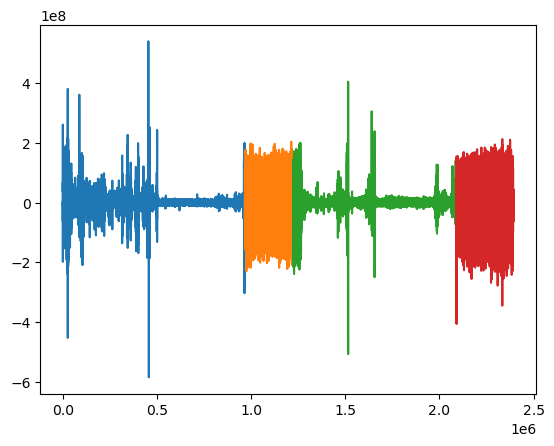

In [589]:
plt.plot(activity_segments[0][1])
plt.plot(activity_segments[1][1])
plt.plot(activity_segments[2][1])
plt.plot(activity_segments[3][1])

# Moment of truth...let's try this approach on someone else

In [611]:
new_subject=dfs_test[5][['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']]

b,a =signal.butter(3,(3,60), btype='bandpass', fs=1000)

new_subject_filtered_accels=[]
for i in new_subject:
    filtered_accel=signal.filtfilt(b, a, new_subject[i])
    new_subject_filtered_accels.append(filtered_accel)
    
new_subject_filtered_accels=pd.concat([pd.Series(i) for i in new_subject_filtered_accels], axis=1)

#Decreasing the scale of the data so it is easier to establish minimum height of Amplitude

standard_accels=new_subject_filtered_accels/100000 

standard_accels['time']=dfs_test[5]['time']
new_subject_filtered_accels['time']=dfs_test[5]['time']

In [612]:
standard_accels

,0,1,2,time
0,34.213525,-42.925624,-233.736828,0.000
1,45.113142,-30.452881,-185.633983,0.001
2,55.042526,-17.410512,-143.358789,0.002
3,63.144396,-3.380323,-112.758740,0.003
4,68.819719,11.792879,-98.622093,0.004
...,...,...,...,...
2252995,-17.903679,-855.497298,-1409.659941,2252.995
2252996,-9.721094,-737.903877,-1240.645347,2252.996
2252997,-2.055909,-617.554912,-1066.644214,2252.997
2252998,5.081859,-496.547538,-890.652552,2252.998


In [613]:
whole_signal_peaks, whole_signal_heights=scipy.signal.find_peaks(standard_accels[1], height=(1000,2000), threshold=.62)

whole_signal_peaks=pd.Series(whole_signal_peaks)/1000

In [614]:
def process_peak_times(series_of_peak_times, window_size, threshold=1.5*len(window)+10):
    times=[]
    for i in range(0, len(series_of_peak_times), window_size):
        if series_of_peak_times[i:i+window_size].diff().sum() > threshold:
            pass
        else:
            times.append(series_of_peak_times[i:i+window_size])
    return times

In [615]:
result=process_peak_times(whole_signal_peaks, 75)

result=pd.concat(result, axis=0)

result=result.reset_index()
result['diff']=result[0].diff()

In [616]:
result

,index,0,diff
0,75,772.577,NaN
1,76,772.985,0.408
2,77,773.009,0.024
3,78,774.783,1.774
4,79,775.935,1.152
...,...,...,...
265,490,2249.554,0.093
266,491,2249.731,0.177
267,492,2249.796,0.065
268,493,2249.987,0.191


In [617]:
activity_segment_times=result[result['diff']>50]

#Add the index of the value preceding the change in difference
added_value=activity_segment_times.index[0]-1

activity_segment_times=activity_segment_times.append(result.iloc[added_value])
activity_segment_times=activity_segment_times.append(result.iloc[0])

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/3305336973.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[added_value])
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/3305336973.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[0])


In [619]:
activity_segment_times=activity_segment_times[0]
activity_segment_times=activity_segment_times.sort_values()

activity_segment_times=list(activity_segment_times)
activity_segment_times=[int(i) for i in activity_segment_times]
activity_segment_times.append(0)
activity_segment_times.sort()

In [623]:
activity_segment_times

[0, 772, 948, 1848, 2206]

In [622]:
activity_segment_times=audit_activity_segment_times(activity_segment_times, result)

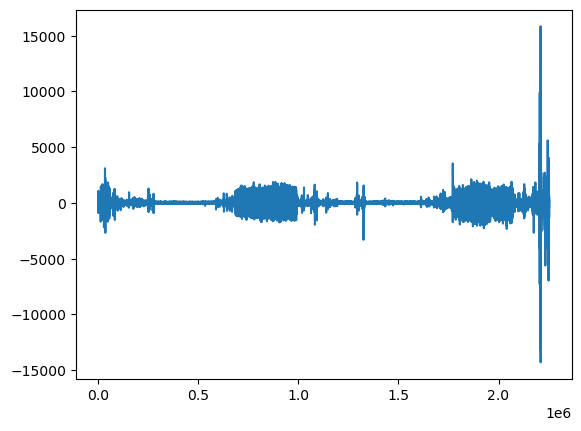

In [621]:
plt.plot(standard_accels[1])

In [624]:
#Return the times to their initial index...in this case x1000 because the sampling rate was 1000 Hz
activity_segment_indexes=[i*1000 for i in activity_segment_times]

time=standard_accels['time'].to_numpy()
cadences=[]
filtered_signals=[]
for idx,segment in enumerate(activity_segment_indexes):
    fs=1000
    cutoff = 0.5
    order=4
    b, a = signal.butter(order, cutoff / (fs / 2), btype="highpass")
    try:
        filtered_signal = signal.filtfilt(b, a, standard_accels[1][activity_segment_indexes[idx]:activity_segment_indexes[idx+1]])
        peaks, _ = signal.find_peaks(filtered_signal, height=(1000,2000))
        step_durations = np.diff(time[activity_segment_indexes[idx]:activity_segment_indexes[idx+1]][peaks])
        step_cadence = 60 / step_durations.mean()
        filtered_signals.append(filtered_signal)
        cadences.append(step_cadence)
        start_time=segment
    except:
        pass

In [625]:
cadences

[7.625015237062761, 82.35604920687796, 8.20465842272668, 41.67005049133135]

In [628]:
segments=pd.cut(standard_accels['time'], activity_segment_times)
activity_segments=[standard_accels[segments == category] for category in segments.cat.categories]
activity_segments

[                  0           1            2     time
 1         45.113142  -30.452881  -185.633983    0.001
 2         55.042526  -17.410512  -143.358789    0.002
 3         63.144396   -3.380323  -112.758740    0.003
 4         68.819719   11.792879   -98.622093    0.004
 5         71.807947   27.930531  -104.261245    0.005
 ...             ...         ...          ...      ...
 771996 -1875.663855  -31.040911  1355.013385  771.996
 771997 -1872.092935  -80.050480  1393.307553  771.997
 771998 -1836.014895 -174.071319  1462.653716  771.998
 771999 -1770.705357 -306.770432  1558.424239  771.999
 772000 -1682.517639 -466.609306  1671.673680  772.000
 
 [772000 rows x 4 columns],
                   0            1            2     time
 772001 -1579.694687  -638.460559  1790.343537  772.001
 772002 -1470.760960  -806.039878  1901.179342  772.002
 772003 -1363.086483  -954.425851  1991.815951  772.003
 772004 -1262.031414 -1072.030492  2052.510619  772.004
 772005 -1170.707909 -1151.755

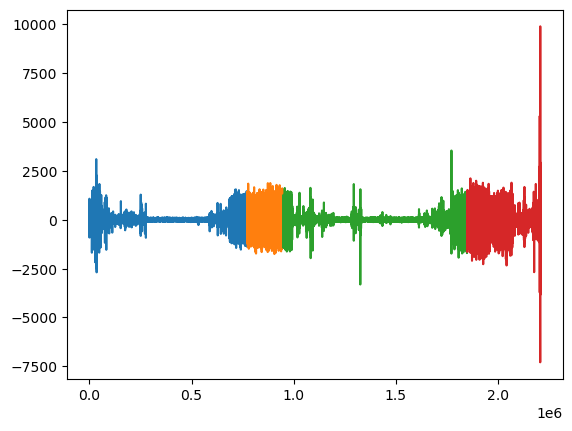

In [629]:
plt.plot(activity_segments[0][1])
plt.plot(activity_segments[1][1])
plt.plot(activity_segments[2][1])
plt.plot(activity_segments[3][1])

# Honestly, not terrible, gonna do another new subject and see and then see how I can make it better if in fact it does continue to somewhat work

In [630]:
new_subject=dfs_test[1][['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']]

b,a =signal.butter(3,(3,60), btype='bandpass', fs=1000)

new_subject_filtered_accels=[]
for i in new_subject:
    filtered_accel=signal.filtfilt(b, a, new_subject[i])
    new_subject_filtered_accels.append(filtered_accel)
    
new_subject_filtered_accels=pd.concat([pd.Series(i) for i in new_subject_filtered_accels], axis=1)

#Decreasing the scale of the data so it is easier to establish minimum height of Amplitude

standard_accels=new_subject_filtered_accels/100000 

standard_accels['time']=dfs_test[1]['time']
new_subject_filtered_accels['time']=dfs_test[1]['time']

In [631]:
standard_accels

,0,1,2,time
0,54.918657,-12.974855,261.310781,0.000
1,59.473895,-9.426833,265.579612,0.001
2,63.454893,-5.682711,269.127459,0.002
3,66.439397,-1.617766,271.441440,0.003
4,68.142369,2.839455,272.281662,0.004
...,...,...,...,...
3937995,-950.902920,-1969.554753,-376.318314,3937.995
3937996,-833.690083,-1716.717994,-324.653093,3937.996
3937997,-717.695826,-1460.249887,-274.951316,3937.997
3937998,-603.921631,-1204.001525,-227.420815,3937.998


In [632]:
whole_signal_peaks, whole_signal_heights=scipy.signal.find_peaks(standard_accels[1], height=(1000,2000), threshold=.62)

whole_signal_peaks=pd.Series(whole_signal_peaks)/1000

In [633]:
result=process_peak_times(whole_signal_peaks, 75)

result=pd.concat(result, axis=0)

result=result.reset_index()
result['diff']=result[0].diff()

In [635]:
whole_signal_peaks

0         0.170
1       126.996
2       128.997
3       129.508
4       130.922
         ...   
859    3935.985
860    3936.721
861    3936.746
862    3937.166
863    3937.383
Length: 864, dtype: float64

In [634]:
result

,index,0,diff
0,450,3689.013,NaN
1,451,3689.054,0.041
2,452,3689.159,0.105
3,453,3689.234,0.075
4,454,3689.256,0.022
...,...,...,...
409,859,3935.985,0.591
410,860,3936.721,0.736
411,861,3936.746,0.025
412,862,3937.166,0.420


In [640]:
activity_segment_times=result[result['diff']>50]

#Add the index of the value preceding the change in difference
#added_value=activity_segment_times.index[0]-1..commented out because of error...good thing to add in ultimate function

activity_segment_times=activity_segment_times.append(result.iloc[added_value])
activity_segment_times=activity_segment_times.append(result.iloc[0])

activity_segment_times=activity_segment_times[0]
activity_segment_times=activity_segment_times.sort_values()

activity_segment_times=list(activity_segment_times)
activity_segment_times=[int(i) for i in activity_segment_times]
activity_segment_times.append(0)
activity_segment_times.sort()

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/757702477.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[added_value])
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/757702477.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[0])


In [641]:
activity_segment_times

[0, 3689, 3784]

In [649]:
activity_segment_times=audit_activity_segment_times(activity_segment_times, result)

ValueError: time_segments missing values. Len must be equal to 5. List is currently: [0, 3689, 3784]

In [646]:
activity_segment_times

[0, 3689, 3784]

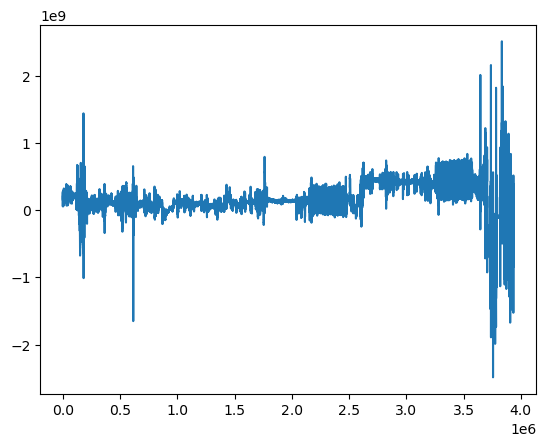

In [694]:
plt.plot(dfs_test[1]['Accelerometer_Y'])

# This subject's data is very messy and unclear so not surprised it did not work. It is hard to even visually assess where periods of activity start and stop as seen above

going to continue on other subject

In [664]:

#Subject with lots of data...may be messy and not work
new_subject=dfs_test[8][['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']]

b,a =signal.butter(3,(3,60), btype='bandpass', fs=1000)

new_subject_filtered_accels=[]
for i in new_subject:
    filtered_accel=signal.filtfilt(b, a, new_subject[i])
    new_subject_filtered_accels.append(filtered_accel)
    
new_subject_filtered_accels=pd.concat([pd.Series(i) for i in new_subject_filtered_accels], axis=1)

#Decreasing the scale of the data so it is easier to establish minimum height of Amplitude

standard_accels=new_subject_filtered_accels/100000 

standard_accels['time']=dfs_test[8]['time']
new_subject_filtered_accels['time']=dfs_test[8]['time']

In [665]:
whole_signal_peaks, whole_signal_heights=scipy.signal.find_peaks(standard_accels[1], height=(1000,2000), threshold=.62)

whole_signal_peaks=pd.Series(whole_signal_peaks)/1000

In [666]:
standard_accels

,0,1,2,time
0,16.444481,74.696226,47.676721,0.000
1,23.442698,116.216441,123.371888,0.001
2,27.912483,153.811176,186.571800,0.002
3,27.588596,183.945760,226.268330,0.003
4,20.786675,203.911270,234.265700,0.004
...,...,...,...,...
3658995,-44.500230,-618.273485,-328.479206,3658.995
3658996,-38.094870,-538.951901,-294.676380,3658.996
3658997,-31.476680,-455.860871,-260.110932,3658.997
3658998,-24.781566,-370.801243,-225.258740,3658.998


In [668]:
result=process_peak_times(whole_signal_peaks, 75)

result=pd.concat(result, axis=0)

result=result.reset_index()
result['diff']=result[0].diff()

In [669]:
result

,index,0,diff
0,75,2121.076,NaN
1,76,2121.093,0.017
2,77,2121.444,0.351
3,78,2122.483,1.039
4,79,2122.950,0.467
...,...,...,...
535,835,3656.234,0.226
536,836,3656.264,0.030
537,837,3656.402,0.138
538,838,3656.428,0.026


In [670]:
activity_segment_times=result[result['diff']>50]

#Add the index of the value preceding the change in difference
added_value=activity_segment_times.index[0]-1
activity_segment_times=activity_segment_times.append(result.iloc[added_value])
activity_segment_times=activity_segment_times.append(result.iloc[0])

activity_segment_times=activity_segment_times[0]
activity_segment_times=activity_segment_times.sort_values()

activity_segment_times=list(activity_segment_times)
activity_segment_times=[int(i) for i in activity_segment_times]
activity_segment_times.append(0)
activity_segment_times.sort()

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/325102324.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[added_value])
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/325102324.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[0])


In [671]:
activity_segment_times

[0, 2121, 2341, 3331, 3650]

In [672]:
activity_segment_times=audit_activity_segment_times(activity_segment_times, result)

In [673]:
activity_segment_times

[0, 2121, 2341, 3331, 3650]

In [674]:
segments=pd.cut(standard_accels['time'], activity_segment_times)
activity_segments=[standard_accels[segments == category] for category in segments.cat.categories]
activity_segments

[                  0            1            2      time
 1         23.442698   116.216441   123.371888     0.001
 2         27.912483   153.811176   186.571800     0.002
 3         27.588596   183.945760   226.268330     0.003
 4         20.786675   203.911270   234.265700     0.004
 5          6.590833   212.107555   206.082549     0.005
 ...             ...          ...          ...       ...
 2120996 -499.376231  -727.655980   909.151414  2120.996
 2120997 -499.428853  -729.406199   904.787776  2120.997
 2120998 -471.521672  -794.897326   991.755982  2120.998
 2120999 -417.712767  -915.791646  1158.311914  2120.999
 2121000 -342.993593 -1076.346376  1382.217357  2121.000
 
 [2121000 rows x 4 columns],
                   0            1            2      time
 2121001 -254.221987 -1255.796020  1634.088669  2121.001
 2121002 -158.677948 -1431.837206  1882.294978  2121.002
 2121003  -62.801107 -1584.133727  2097.884712  2121.003
 2121004   28.523866 -1696.944757  2258.286685  2121.004


In [675]:
#Return the times to their initial index...in this case x1000 because the sampling rate was 1000 Hz
activity_segment_indexes=[i*1000 for i in activity_segment_times]

time=standard_accels['time'].to_numpy()
cadences=[]
filtered_signals=[]
for idx,segment in enumerate(activity_segment_indexes):
    fs=1000
    cutoff = 0.5
    order=4
    b, a = signal.butter(order, cutoff / (fs / 2), btype="highpass")
    try:
        filtered_signal = signal.filtfilt(b, a, standard_accels[1][activity_segment_indexes[idx]:activity_segment_indexes[idx+1]])
        peaks, _ = signal.find_peaks(filtered_signal, height=(1000,2000))
        step_durations = np.diff(time[activity_segment_indexes[idx]:activity_segment_indexes[idx+1]][peaks])
        step_cadence = 60 / step_durations.mean()
        filtered_signals.append(filtered_signal)
        cadences.append(step_cadence)
        start_time=segment
    except:
        pass

In [676]:
cadences

[2.8578273344110703, 181.7115261312633, 13.524263316800306, 39.18810289389068]

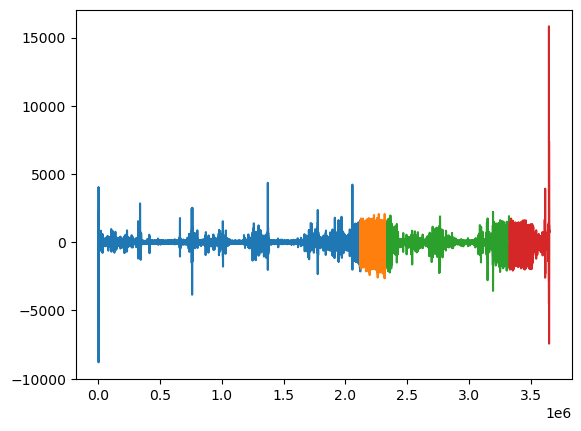

In [677]:
plt.plot(activity_segments[0][1])
plt.plot(activity_segments[1][1])
plt.plot(activity_segments[2][1])
plt.plot(activity_segments[3][1])

# Again, not too bad. I need to remove all that noise at the beginning but it certainly changes when walking begings and changes again when walking stops

Trying on Subject 11 with very clean data

In [678]:
new_subject=dfs_test[11][['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']]

b,a =signal.butter(3,(3,60), btype='bandpass', fs=1000)

new_subject_filtered_accels=[]
for i in new_subject:
    filtered_accel=signal.filtfilt(b, a, new_subject[i])
    new_subject_filtered_accels.append(filtered_accel)
    
new_subject_filtered_accels=pd.concat([pd.Series(i) for i in new_subject_filtered_accels], axis=1)

#Decreasing the scale of the data so it is easier to establish minimum height of Amplitude

standard_accels=new_subject_filtered_accels/100000 

standard_accels['time']=dfs_test[8]['time']
new_subject_filtered_accels['time']=dfs_test[8]['time']

In [679]:
whole_signal_peaks, whole_signal_heights=scipy.signal.find_peaks(standard_accels[1], height=(1000,2000), threshold=.62)

whole_signal_peaks=pd.Series(whole_signal_peaks)/1000

result=process_peak_times(whole_signal_peaks, 75)

result=pd.concat(result, axis=0)

result=result.reset_index()
result['diff']=result[0].diff()

In [680]:
activity_segment_times=result[result['diff']>50]

#Add the index of the value preceding the change in difference
added_value=activity_segment_times.index[0]-1
activity_segment_times=activity_segment_times.append(result.iloc[added_value])
activity_segment_times=activity_segment_times.append(result.iloc[0])

activity_segment_times=activity_segment_times[0]
activity_segment_times=activity_segment_times.sort_values()

activity_segment_times=list(activity_segment_times)
activity_segment_times=[int(i) for i in activity_segment_times]
activity_segment_times.append(0)
activity_segment_times.sort()

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/325102324.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[added_value])
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_24287/325102324.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_segment_times=activity_segment_times.append(result.iloc[0])


In [682]:
activity_segment_times

[0, 698, 953, 1718, 2060]

In [683]:
activity_segment_times=audit_activity_segment_times(activity_segment_times, result)

In [684]:
activity_segment_times

[0, 698, 953, 1718, 2060]

In [685]:
segments=pd.cut(standard_accels['time'], activity_segment_times)
activity_segments=[standard_accels[segments == category] for category in segments.cat.categories]
activity_segments

[                  0           1           2     time
 1        -15.901421  -15.205550  -16.194543    0.001
 2        -14.790380  -31.880833  -22.024879    0.002
 3        -12.968629  -44.795812  -25.695954    0.003
 4        -10.239790  -52.607263  -26.495636    0.004
 5         -6.564447  -54.546027  -24.092608    0.005
 ...             ...         ...         ...      ...
 697996  1354.807032  519.456775  364.674222  697.996
 697997  1377.904505  559.066466  354.034171  697.997
 697998  1347.256455  588.927998  324.261680  697.998
 697999  1267.407468  609.426959  276.315802  697.999
 698000  1148.196162  621.608904  213.406596  698.000
 
 [698000 rows x 4 columns],
                   0           1           2     time
 698001  1002.761807  626.702812  140.554067  698.001
 698002   844.893591  625.624736   63.778247  698.002
 698003   686.725298  618.709195  -10.825732  698.003
 698004   537.426373  605.770050  -77.885696  698.004
 698005   402.894711  586.400714 -133.306815  698.00

In [686]:
#Return the times to their initial index...in this case x1000 because the sampling rate was 1000 Hz
activity_segment_indexes=[i*1000 for i in activity_segment_times]

time=standard_accels['time'].to_numpy()
cadences=[]
filtered_signals=[]
for idx,segment in enumerate(activity_segment_indexes):
    fs=1000
    cutoff = 0.5
    order=4
    b, a = signal.butter(order, cutoff / (fs / 2), btype="highpass")
    try:
        filtered_signal = signal.filtfilt(b, a, standard_accels[1][activity_segment_indexes[idx]:activity_segment_indexes[idx+1]])
        peaks, _ = signal.find_peaks(filtered_signal, height=(1000,2000))
        step_durations = np.diff(time[activity_segment_indexes[idx]:activity_segment_indexes[idx+1]][peaks])
        step_cadence = 60 / step_durations.mean()
        filtered_signals.append(filtered_signal)
        cadences.append(step_cadence)
        start_time=segment
    except:
        pass

In [687]:
cadences

[9.184565503657229, 144.64870467948768, 7.531754977365508, 148.30020317965693]

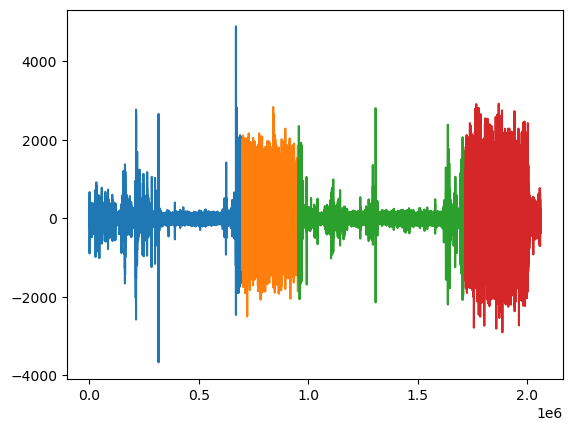

In [688]:
plt.plot(activity_segments[0][1])
plt.plot(activity_segments[1][1])
plt.plot(activity_segments[2][1])
plt.plot(activity_segments[3][1])